# Loaded die: a simple tutorial in choosing priors

A die is loaded so that the expectation of values on its upper face is 4.5. What is the probability distribution?

Example use of the maximum entropy package: the unfair die example from Jaynes, *Probability Theory: The Logic of Science*, 2006.

Suppose you know that the long-run average number on the face of a 6-sided die
tossed many times is 4.5.

What probability $p(x)$ would you assign to rolling $x$ on the next roll?

<table>
<tr><th>x</th><th>1</th><th>2</th><th>3</th><th>4</th><th>5</th><th>6</th></tr>
<tr><td>p(x)</td><td>?</td><td>?</td><td>?</td><td>?</td><td>?</td><td>?</td></tr>
</table>

Constraints:

$$
\begin{align}
E(f_1(X)) = \sum_{x=1}^6 f_1(x) p(x) &= 4.5, \text{where } f_1(x) = x \\
\text{and} \\
\sum_{x=1}^6 p(x) &= 1
\end{align}
$$

This notebook shows how to use the scikit-maxentropy package to find the probability distribution with maximal information entropy subject to these constraints.

In [1]:
import numpy as np
from maxentropy import FeatureTransformer, MinDivergenceModel

In [2]:
samplespace = np.linspace(1, 6, 6, dtype=int)

In [3]:
samplespace

array([1, 2, 3, 4, 5, 6])

In [4]:
def f_1(x):
    return x

In [5]:
features = [f_1]

In [6]:
len(features)

1

In [7]:
model = MinDivergenceModel(features, samplespace)

In [8]:
model.params

array([0.])

In [9]:
k = np.array([4.5])
X = np.atleast_2d(k)

In [10]:
X

array([[4.5]])

In [11]:
model.fit(X)

MinDivergenceModel(algorithm='CG', features=[<function f_1 at 0x10d40e158>],
                   matrix_format='csr_matrix', prior_log_pdf=None,
                   samplespace=array([1, 2, 3, 4, 5, 6]), vectorized=True,
                   verbose=0)

In [12]:
p = model.probdist()
p

array([0.05435317, 0.07877155, 0.11415998, 0.1654468 , 0.23977444,
       0.34749407])

### Now try minimizing KL divergence from a constant prior. We should get the same model.

In [13]:
log_prior = np.log(np.ones(6)/6)

In [14]:
log_prior

array([-1.79175947, -1.79175947, -1.79175947, -1.79175947, -1.79175947,
       -1.79175947])

In [15]:
np.exp(log_prior).sum()

1.0000000000000002

In [16]:
# Another way avoiding overflow:
from scipy.special import logsumexp
np.exp(logsumexp(log_prior))

1.0

In [41]:
@np.vectorize
def prior_log_pdf(x):
    return log_prior[x-1]  # zero-based indexing offset

In [18]:
prior_log_pdf(samplespace)

array([-1.79175947, -1.79175947, -1.79175947, -1.79175947, -1.79175947,
       -1.79175947])

In [19]:
type(prior_log_pdf)

numpy.vectorize

In [20]:
model2 = MinDivergenceModel(features, samplespace, prior_log_pdf=prior_log_pdf)

In [21]:
model2.fit(X)

MinDivergenceModel(algorithm='CG', features=[<function f_1 at 0x10d40e158>],
                   matrix_format='csr_matrix',
                   prior_log_pdf=<numpy.vectorize object at 0x1a1cd3f630>,
                   samplespace=array([1, 2, 3, 4, 5, 6]), vectorized=True,
                   verbose=0)

In [22]:
p2 = model2.probdist()
p2

array([0.05435317, 0.07877155, 0.11415998, 0.1654468 , 0.23977444,
       0.34749407])

In [23]:
np.allclose(p, p2)

True

In [24]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Model 1: Probability $p(x)$ of each die face $x$')

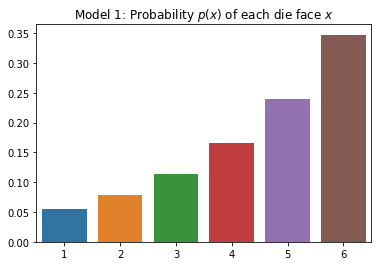

In [25]:
sns.barplot(np.arange(1, 7), model.probdist())
plt.title('Model 1: Probability $p(x)$ of each die face $x$')

### Minimizing KL divergence from a different distribution

Now we demonstrate minimizing KL divergence from a different distribution: $p(1) = p(2) = p(3)=p(4)=p(5)=0.1$ and $p(6) = 0.5$, still subject to the same constraint on the expectation being 4.5

In [42]:
prior2 = np.zeros(6)

In [43]:
prior2[:4] = 0.1
prior2[4] = 0.5
prior2[5] = 0.1

In [44]:
prior2

array([0.1, 0.1, 0.1, 0.1, 0.5, 0.1])

In [45]:
prior2.sum()

1.0

In [46]:
prior_log_probs = np.log(prior2)

In [39]:
prior_log_probs

array([-2.30258509, -2.30258509, -2.30258509, -2.30258509, -0.69314718,
       -2.30258509])

In [47]:
@np.vectorize
def prior_log_pdf(x):
    return prior_log_probs[x-1]  # zero-based indexing offset

In [69]:
model3 = MinDivergenceModel(features, samplespace,
                            prior_log_pdf=prior_log_pdf,
                            algorithm='BFGS',
                            verbose=False)

#### Before fitting the model, what do we have?

In [70]:
model3.probdist()

array([0.1, 0.1, 0.1, 0.1, 0.5, 0.1])

In [71]:
np.allclose(model.probdist(), model3.probdist())

False

Text(0.5, 1.0, 'Model 2: Probability $p(x)$ of each die face $x$')

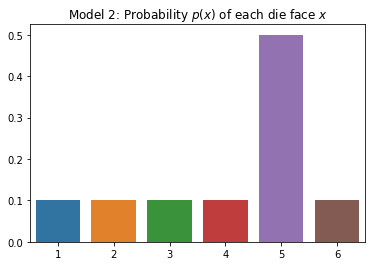

In [72]:
sns.barplot(np.arange(1, 7), model3.probdist())
plt.title('Model 2: Probability $p(x)$ of each die face $x$')

Are the constraints satisfied?

In [73]:
model3.expectations()

array([4.1])

No. (We haven't fitted the model yet.)

In [74]:
k

array([4.5])

In [75]:
np.allclose(model3.expectations(), k)

False

#### What is the KL divergence before fitting the model ?

In [76]:
from scipy.stats import entropy

In [77]:
np.exp(model3.priorlogprobs)

array([0.1, 0.1, 0.1, 0.1, 0.5, 0.1])

In [78]:
model3.probdist()

array([0.1, 0.1, 0.1, 0.1, 0.5, 0.1])

In [79]:
model3.divergence()

-3.330669073875469e-16

Actually, this is zero, with numerical imprecision. The true KL divergence is always >= 0 by definition.

In [80]:
np.allclose(model3.divergence(), 0)

True

In [81]:
# Verify with scipy.stats.entropy():
D = entropy(model3.probdist(), np.exp(model3.priorlogprobs))
D

2.2204460492503128e-16

In [82]:
np.allclose(model3.divergence(), D)

True

#### Answer: zero.

Before calling model3.fit(X), model3 is identical to the prior.

### Now we fit the model (place constraints on it):

In [83]:
model3.fit(X)

MinDivergenceModel(algorithm='BFGS', features=[<function f_1 at 0x10d40e158>],
                   matrix_format='csr_matrix',
                   prior_log_pdf=<numpy.vectorize object at 0x1a20d3c438>,
                   samplespace=array([1, 2, 3, 4, 5, 6]), vectorized=True,
                   verbose=False)

In [84]:
model3.probdist()

array([0.05125862, 0.06272495, 0.07675624, 0.09392627, 0.57468582,
       0.1406481 ])

Text(0.5, 1.0, 'Model 2: Probability $p(x)$ of each die face $x$')

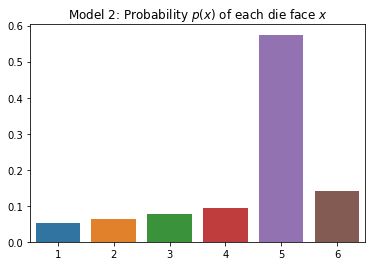

In [85]:
sns.barplot(np.arange(1, 7), model3.probdist())
plt.title('Model 2: Probability $p(x)$ of each die face $x$')

#### Verify that the expectation (of the sole feature) is 4.5:

In [86]:
model3.expectations()

array([4.5])

In [88]:
np.sum(model3.probdist() * model3.samplespace)

4.5000000000114175